In [ ]:
%matplotlib inline

Define the model
----------------




In [272]:
import math
from typing import Tuple
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
from sklearn import preprocessing

class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int, 
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout) #NOTE d_model is the embedding size
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        # self.encoder = nn.Embedding(ntoken, d_model) # NOTE: Do not need embedding for IPS, the data itself has 384 dimensional data
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, ntoken)
        self.doa_embedding = DOAEncoding(d_model)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        # self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_doa:Tensor, src_mask: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size] #! Make the src to be a tuple, (csi, doa)
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        # src = self.encoder(src) * math.sqrt(self.d_model) #! the input is 35(just consider it to be # of batches) by 20, the output is 35 by 20 by 200. The embedding turns the indices into vectors of size 200.
        
        # note: with DOA         
        src_doa = self.doa_embedding(src_doa) #!HACK: NOTE: DOA embedding should be in from of the pos encoding !!
        # print('src and src_doa shape', src.shape, src_doa.shape)
        # src = src + src_doa
        src = src_doa

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask) #! the output is the output of the final fully-connected layer of 200 dimension. The dimension here is still the same as 35 by 20 by 200
        
        output = self.decoder(output) #! The linear layer in the decoder maps the input from 35 by 20 by 200 to 35 by 20 by ntoken (好像是两万多)
        return output

def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

In [161]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000): # max_len means the maximum time steps or word length
        super().__init__()
        self.dropout = nn.Dropout(p=dropout) # do not understand why you need dropout here

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)) #1/10000^(2i/dim_model)) #! exp(ln(x))=x, therefore, exp(ln(1/10000^(2i/dim_model)))) = exp(2i/dim_model)*(-ln(10000))
        pe = torch.zeros(max_len, 1, d_model) #NOTE: Row always means the 
        pe[:, 0, 0::2] = torch.sin(position * div_term) #PE(pos, 2i) = sin(pos/10000^(2i/dim_model))
        pe[:, 0, 1::2] = torch.cos(position * div_term) #PE(pos, 2i) = cos(pos/10000^(2i/dim_model))
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [162]:
class DOAEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.5): # max_len means the maximum time steps or word length
        super().__init__()
        self.dropout = nn.Dropout(p=dropout) # do not understand why you need dropout here

        self.embedding_layer = nn.Embedding(num_embeddings=512, # zzf: this value depends on the unique value of the DoA
                               embedding_dim=d_model)
                            #    padding_idx=1)
    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = self.embedding_layer(x)
        # return self.embedding_layer(x)
        return self.dropout(x)

Load and batch data
-------------------




In [18]:
import scipy.io as sio
from scipy.io import loadmat, savemat
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from einops import rearrange,reduce,repeat
import glob

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

##### load training data

In [268]:
fileName = 'matlab_input_data/2'
dirc = os.getcwd()
data_set = []
data_doa_set = []
dataPath = os.path.join(dirc,fileName)
if os.path.exists(dataPath):
    for root,dirs,files in os.walk(dataPath):
        for file in files:
            if file.startswith('features'):
                inputPath = os.path.join(root,file)
                print(inputPath)
                input_data_train = sio.loadmat(inputPath)
                input_data_train = torch.from_numpy(input_data_train['features'])
                data_set.append(input_data_train) #NOTE: put all the train_data of different SNR into one list
            elif file.startswith('doa'):
                inputPath = os.path.join(root,file)
                print(inputPath)
                
                input_data_train_doa = sio.loadmat(inputPath)
                input_data_train_doa = torch.from_numpy(input_data_train_doa['doa_input'])
                input_data_train_doa = torch.squeeze(input_data_train_doa)
                data_doa_set.append(input_data_train_doa) #NOTE: put all the train_data of different SNR into one list
else:
    print('the path does not exist!')
    
# Stack all the samples from different SNR together along a new dimension.
# data_concatenate = torch.cat(data_set)
data_stack = torch.stack(data_set)
print('the stacked dataset is ', data_stack.shape)
data_doa_stack = torch.stack(data_doa_set)
print('the stacked doa dataset is ', data_doa_stack.shape)

# # Shuffle the data along the first dimension (the data is concatenated along the first dimension)
# perm_length = torch.randperm(data_stack.shape[0])
# data_stack = data_stack[perm_length]
# data_doa_stack = data_doa_stack[perm_length]

print(f'the shuffled data shape is {data_stack.shape}\n',
      f'{data_stack.shape[0]} is the number of SNR\n',
      f'{data_stack.shape[1]} is the number of CSI samples\n',
      f'{data_stack.shape[2]} is the number of antenna links\n',
      f'{data_stack.shape[3]} is the number of APs\n',
      f'{data_stack.shape[4]} is the number of positions')

print(f'the shuffled data shape is {data_doa_stack.shape}\n',
      f'{data_doa_stack.shape[0]} is the number of SNR\n',
      f'{data_doa_stack.shape[1]} is the number of positions\n')

c:\Users\HYPC300\OneDrive - 한양대학교\GitHub\Deeplearning-Autoencoder-DOA\[3]Pytorch\[3]Transformer_DOA\matlab_input_data/2\doa_input_1d_00snr.mat
c:\Users\HYPC300\OneDrive - 한양대학교\GitHub\Deeplearning-Autoencoder-DOA\[3]Pytorch\[3]Transformer_DOA\matlab_input_data/2\doa_input_1d_01snr.mat
c:\Users\HYPC300\OneDrive - 한양대학교\GitHub\Deeplearning-Autoencoder-DOA\[3]Pytorch\[3]Transformer_DOA\matlab_input_data/2\doa_input_1d_02snr.mat
c:\Users\HYPC300\OneDrive - 한양대학교\GitHub\Deeplearning-Autoencoder-DOA\[3]Pytorch\[3]Transformer_DOA\matlab_input_data/2\doa_input_1d_03snr.mat
c:\Users\HYPC300\OneDrive - 한양대학교\GitHub\Deeplearning-Autoencoder-DOA\[3]Pytorch\[3]Transformer_DOA\matlab_input_data/2\doa_input_1d_04snr.mat
c:\Users\HYPC300\OneDrive - 한양대학교\GitHub\Deeplearning-Autoencoder-DOA\[3]Pytorch\[3]Transformer_DOA\matlab_input_data/2\doa_input_1d_05snr.mat
c:\Users\HYPC300\OneDrive - 한양대학교\GitHub\Deeplearning-Autoencoder-DOA\[3]Pytorch\[3]Transformer_DOA\matlab_input_data/2\doa_input_1d_06snr.mat

##### preprocessing training data and DOA data

In [269]:
n_trajectories = 49
n_pts_trajectory = 79
# Change the original data dimension [3871, 4, 4, 24] to [79 x 49 x 4 x 4 x 24] 
## NOTE: The following code is for training dataset of multiple SNR case
input_data_reshape = rearrange(data_stack, 'a b c d e-> e (d c b) a') 
## NOTE: The following code is for training dataset of single SNR case
# input_train_data_reshape = rearrange((input_data_shuffle), 'a b c d-> d (c b a)')
print('input_train_data_reshape',input_data_reshape.shape)

# # #NOTE: Scaling: make the mean of each dimension (744 * 9 *4 dimensions) to be 0, and the standard deviation to be 1
# input_train_data_reshape = rearrange((input_data_reshape), 'a b c-> b a c')
# scaler = preprocessing.StandardScaler()
# # scaler = preprocessing.MinMaxScaler() # feature_range=(-1,1)
# train_data_scale = scaler.fit_transform(input_train_data_reshape)
# train_data_scale = rearrange((train_data_scale), 'a b c-> b a c')

# # print(train_data_scale[10])
# # print(np.mean(train_data_scale, axis=0))
# # print(np.std(train_data_scale, axis=0))

train_data_trajectory = (input_data_reshape).chunk(n_pts_trajectory) #! divide the data into chunks
train_data = torch.stack([item for item in train_data_trajectory]).to(device) # [79 x 49 x 768]
train_data = train_data.type(torch.cuda.FloatTensor) #! BUG: Training must use `FloatTensor` type
train_data = rearrange((train_data), 'a b c d-> d a b c')
print('training data size',train_data.shape) #note the third dimension is # of SNR from -10 to 30


data_doa_stack_reshape = rearrange((data_doa_stack), 'a b-> b a')
input_data_doa = data_doa_stack_reshape.type(torch.cuda.LongTensor) #! HACK: Embedding layer only accepts the LongTensor Type
data_doa_chunk = input_data_doa.chunk(n_pts_trajectory) #! divide the data into chunks
train_data_doa = torch.stack([item for item in data_doa_chunk]).to(device) # [79 x 49 x 4 x 4 x 24]
train_data_doa = rearrange((train_data_doa), 'a b c->c a b')

print('doa data size',train_data_doa.shape)

input_train_data_reshape torch.Size([3871, 768, 31])
training data size torch.Size([31, 79, 49, 768])
doa data size torch.Size([31, 79, 49])


In [271]:
torch.save(train_data, 'features_all_snr_from0_to_30.pt') 
torch.save(train_data_doa, 'doa_all_snr_from0_to_30.pt') 
# torch.load('file.pt')

#### Generate Labels for all positions 

In [225]:
labels_ips = torch.arange(0,3871)
# Change the label dimension from 1d to [79 x 49]
labels_ips = labels_ips.reshape(49, 79).t().to(device)
print('label shape',labels_ips.shape)

label shape torch.Size([79, 49])


In [184]:
n_pts_once = 79 #NOTE: batch dimension N, the length of each batch. In IPS, it means the number of points considered at once
def get_batch(source: Tensor, source_doa: Tensor, label: Tensor, i: int) -> Tuple[Tensor, Tensor]: 
    """
    Args:
        source: Tensor, shape [num_pts, batch_size] NOTE: batch_size = # of trajectories
        label: Tensor, shape [num_pts, batch_size]
        i: int

    Returns:
        tuple (data, target), where data has shape [num_pts, batch_size] and
        target has shape [num_pts * batch_size]
    """
    seq_len = min(n_pts_once, len(source) - 1 - i)  #! The actual value for i is [0 35 70 105,...]
    data = source[i:i+seq_len]
    data_doa = source_doa[i:i+seq_len]
    target = label[i+1:i+1+seq_len].reshape(-1) #! reshape(-1) will unfold the matrix from the higher dimension to the lower dimension
    return data,data_doa,target

Initiate an instance
--------------------




In [262]:
ntokens = 3871  # there are 3871 points!!
emsize = 768  # 384 # the data sample dimension for each point (similar to embedding dimension here)
d_hid = 1024  # dimension of the feedforward network model in nn.TransformerEncoder %NOTE: default is 2048
nlayers = 2  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 4  # number of heads in nn.MultiheadAttention
dropout = 0.1  # dropout probability % 0.2
traj_length = 79
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)

Run the model
-------------




In [263]:
import copy
import time

criterion = nn.CrossEntropyLoss()
lr = 5.0  # learning rate
# optimizer = torch.optim.SGD(model.parameters(), lr=lr)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20.0, gamma=0.95) # after one epoch, the LR becomes 95% of the original LR

In [254]:
def train(model: nn.Module, train_data: Tensor, train_data_doa: Tensor) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 10
    start_time = time.time()
    src_mask = generate_square_subsequent_mask(n_pts_once).to(device)
    num_batches = traj_length // n_pts_once
    
    # for    batch, i in enumerate(range(0, train_data.size(0) - 1, n_pts_once)): #(0 35 70 ...) #NOTE: `-1` is for batching the target value
    for batch, i in enumerate(range(0, train_data.size(0) - 1, 1)): #(0 35 70 ...) #NOTE: `-1` is for batching the target value
        data, data_doa, targets = get_batch(train_data,train_data_doa, labels_ips, i) # i = 0, 35,70, ... len(train_data) #! The size of data is 35 by 20, 20 is the batch size
        batch_size = data.size(0)

        if batch_size != n_pts_once:  # only on last batch
            src_mask = src_mask[:batch_size, :batch_size] 
        output = model(data, data_doa, src_mask) #! The shape of the output is (35, 20, 28782)
        loss = criterion(output.view(-1, ntokens), targets) #! out.view(-1,ntokens) will make the shape (35,20,28782) to (700,28782)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        

        # total_loss += loss.item()
        # if batch % log_interval == 0 and batch > 0:
        #     lr = scheduler.get_last_lr()[0]
        #     ms_per_batch = (time.time() - start_time) * 1000 / log_interval
        #     cur_loss = total_loss / log_interval
        #     ppl = math.exp(cur_loss)
        #     print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
        #             f'lr {lr:02.6f} | ms/batch {ms_per_batch:5.2f} | '
        #             f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
        #     total_loss = 0
        #     start_time = time.time()

def evaluate(model: nn.Module, eval_data: Tensor, eval_data_doa:Tensor, labels: Tensor) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    src_mask = generate_square_subsequent_mask(n_pts_once).to(device)
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, n_pts_once):
            data, data_doa,targets = get_batch(eval_data, eval_data_doa,labels, i)
            batch_size = data.size(0)
            if batch_size != n_pts_once:
                src_mask = src_mask[:batch_size, :batch_size]
            output = model(data, data_doa,src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += batch_size * criterion(output_flat, targets).item()
    return total_loss / (len(eval_data) - 1)

Loop over epochs. Save the model if the validation loss is the best
we've seen so far. Adjust the learning rate after each epoch.



In [264]:
import glob
best_val_loss = float('inf') #float('inf') 1.8
epochs = 1000
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    # for snr in range(len(train_data)):
    for _ in range(1):
        snr = 10
        train_data_snr = train_data[snr].to(device)
        train_data_doa_snr = train_data_doa[snr].to(device)
        train(model, train_data_snr, train_data_doa_snr)
        test_snr = train_data[snr].to(device)
        test_doa_snr = train_data_doa[snr].to(device)
        
        val_loss = evaluate(model, test_snr,test_doa_snr, labels_ips)  # val_data
        val_ppl = math.exp(val_loss)
        elapsed = time.time() - epoch_start_time
        
        if epoch % 2 == 0:
            print('-' * 89)
            print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
                f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f} |'
                f'SNR of the dataset is {snr}')
            print('-' * 89)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            lr = scheduler.get_last_lr()[0]

            # Save the model 
            fileName = f'model_numLayer_{nlayers}_numHead_{nhead}_dropout_{dropout}_batchsize_{n_pts_once}_minLoss_{val_loss:.3f}_lr_{lr:.6f}_snrTrainingData_{snr}_epoch_{epoch}.pth'
            PATH = 'model_10dBsNR_8antenna_train_on_both_doa_and_CSI'
            if not os.path.exists(PATH):
                os.makedirs(PATH)
            fullPath = os.path.join(PATH, fileName)
            # searchWord = f'model_numLayer_{nlayers}_numHead_{nhead}_dropout_{dropout}_batchsize_{n_pts_once}'
            # files = glob.glob(f'model/{searchWord}*.pth')
            # for i in files:
            #     os.remove(i)
            torch.save(best_model.state_dict(), fullPath)
    scheduler.step()

-----------------------------------------------------------------------------------------
| end of epoch   2 | time:  1.95s | valid loss  7.13 | valid ppl  1246.72 |SNR of the dataset is 10
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   4 | time:  1.95s | valid loss  4.91 | valid ppl   135.96 |SNR of the dataset is 10
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   6 | time:  1.88s | valid loss  2.87 | valid ppl    17.69 |SNR of the dataset is 10
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   8 | time:  1.87s | valid loss  1.79 | valid ppl     6

KeyboardInterrupt: 

In [227]:
best_model = copy.deepcopy(model)
lr = scheduler.get_last_lr()[0]

# Save the model 
fileName = f'model_numLayer_{nlayers}_numHead_{nhead}_dropout_{dropout}_batchsize_{n_pts_once}_minLoss_{val_loss:.3f}_lr_{lr:.6f}_snrTrainingData_{snr}_epoch_{epoch}.pth'
PATH = 'model_train_on_0dB_to_30dB_SNR_8antenna_DOA'
if not os.path.exists(PATH):
    os.makedirs(PATH)
fullPath = os.path.join(PATH, fileName)
# searchWord = f'model_numLayer_{nlayers}_numHead_{nhead}_dropout_{dropout}_batchsize_{n_pts_once}'
# files = glob.glob(f'model/{searchWord}*.pth')
# for i in files:
#     os.remove(i)
torch.save(best_model.state_dict(), fullPath)

In [ ]:
fileName = f'model_numLayer_{nlayers}_numHead_{nhead}_dropout_{dropout}_batchsize_{n_pts_once}_minLoss_{val_loss:.3f}_lr_{lr:.6f}_epoch_{epoch}.pth'
PATH = 'model'
if not os.path.exists(PATH):
    os.makedirs(PATH)
fullPath = os.path.join(PATH, fileName)
# searchWord = f'model_numLayer_{nlayers}_numHead_{nhead}_dropout_{dropout}_batchsize_{n_pts_once}'
# files = glob.glob(f'model/{searchWord}*.pth')
# for i in files:
#     os.remove(i)
torch.save(best_model.state_dict(), fullPath)

In [279]:
# load the model
new_model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)
# new_model.load_state_dict(torch.load('model_doa_singleSNR\model_numLayer_2_numHead_4_dropout_0.1_batchsize_40_minLoss_0.069_lr_0.000081_epoch_114.pth'))
new_model.load_state_dict(torch.load('model_30dBSNR_8antenna_train_on_DOA_only\model_numLayer_2_numHead_4_dropout_0.1_batchsize_79_minLoss_0.076_lr_0.000086_snrTrainingData_30_epoch_76.pth'))

# new_model.load_state_dict(torch.load('model\model_numLayer_2_numHead_4_dropout_0.1_batchsize_40_minLoss_0.014_lr_0.000060.pth'))
new_model.eval() # to turn off the dropout layer ..

TransformerModel(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (linear1): Linear(in_features=768, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      

Evaluate the best model on the test dataset
-------------------------------------------




#### Estimation Error Table !
1. First, I need to create a 49 x 79 table.
2. 49 is along the x axis, and 79 is along the y axis.
3. The spacing between each point is 0.1cm. 
4. When calculating the error, just need to calculate the distance between the estimated 

In [132]:
def calculate_error(table, trajectory_ind, start_point, predicted, spacing):
    data_length = len(predicted)
    label = table[trajectory_ind][start_point + 1:start_point+data_length + 1]
    predicted_ind = predicted.cpu().numpy()
    dis_sum = 0
    if len(label) != len(predicted):
        predicted_ind = predicted_ind[:-1]
    # print((predicted_ind), (label))
    for x, y in zip(predicted_ind, label):
        pred = np.where(table == y) #NOTE the index of the predicted value in the table
        grd = np.where(table == x) #NOTE the index of the true label in the table
        dis = ((pred[0] - grd[0])**2 + (pred[1] - grd[1])**2)**0.5
        
        
        real_dis = dis * spacing #NOTE: Multiply with the unit
        dis_sum = dis_sum + real_dis
    ave = dis_sum/data_length # calculate the averaged value
    # print(f'the averaged value over {data_length} data points is {ave} cm')
    return ave

#### Methodology to calculate the error
+  First of all, every point should be considered as the starting point once.
+ Then for convenient computation, we consider all the locations starting from the start_point all the way to the second to the end.(Should not include the last location because the last one should be predicted by the previous locations)
+  Then for each test from an arbitrary starting location, the error is calculated between the correct and incorrect locations. Then calculate the average by dividing the length which is from the starting location to the second location to the end.

In [131]:
def predict(model: nn.Module, start_point: Tensor, data_length: Tensor, eval_data: Tensor, eval_data_doa:Tensor) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    src_mask = generate_square_subsequent_mask(n_pts_once).to(device)
    with torch.no_grad():
      if data_length > n_pts_once:
        raise ValueError(f"the data_length should not be greater than the batch_size {n_pts_once}")
      else:
        # if start_point+data_length < 79:
        # data = eval_data[start_point:start_point+data_length]
        # data_doa = eval_data_doa[start_point:start_point+data_length]
        # else:
        data = eval_data[start_point:-1] #NOTE:Consider all the remaining locations in the trajectory
        data_doa = eval_data_doa[start_point:-1] #NOTE:Consider all the remaining locations in the trajectory
        batch_size = data.size(0)
        if batch_size != n_pts_once:
                src_mask = src_mask[:batch_size, :batch_size]
        output = model(data, data_doa,src_mask)
        output_flat = output.view(-1, ntokens)
    return output_flat

#### Test Scenario 1: 
1. the test data is the same data as the training data.
2. the batch size is the same as the training data. (batch_sie <==> n_pts_once)

`Result`: The result is 100% accurate if the same data is put into the model. 

In [ ]:
trajectory_ind = 0 #NOTE: the index of the trajectory from all 49 trajectories.
start_point = 10 # 0, n_pts_once, 2*n_pts_once... #NOTE: the start point in a given trajectory
data_length = 12

test_input = rearrange(train_data, 'a b c -> b a c') # train_data test_data
test_input_doa = rearrange(train_data_doa, 'a b -> b a') # train_data test_data

one_trajectory = rearrange(test_input[trajectory_ind], 'a b -> a 1 b') 
one_trajectory_doa = rearrange(test_input_doa[trajectory_ind], 'a -> a 1') 

predicted = predict(best_model, start_point, data_length, one_trajectory,one_trajectory_doa) # new_model best_model 
# test_ppl = math.exp(test_loss)
print('=' * 89)
# print(predicted.shape)
pre_ind = torch.argmax(predicted,axis=1)
# print(pre_ind.reshape(n_pts_once,-1))
print(f'the predicted locations are {pre_ind.reshape(len(predicted),-1).squeeze()}')
# print(labels_ips.)

print('=' * 89)

#### Test Scenario 2: 
1. the test data is different from the training data. 
2. For example, the batch_size is 20, one of the 20 data, only the first one is valid, the remaining ones will be 0, just to conform with the batch_size during the training.

`Result`: The result is 100% accurate if the same data is put into the model. 

In [ ]:
trajectory_ind = 0 #NOTE: the index of the trajectory from all 49 trajectories.
start_point = 0 # 0, n_pts_once, 2*n_pts_once... #NOTE: the start point in a given trajectory
data_length = 40
test_data_one = test_data[2]

test_input = rearrange(test_data_one.to(device), 'a b c -> b a c') # train_data test_data
print(test_input.shape)

test_input_doa = rearrange(train_data_doa.to(device), 'a b -> b a') # train_data test_data
print(test_input_doa.shape)

# print(test_input.shape)
one_trajectory = rearrange(test_input[trajectory_ind], 'a b -> a 1 b') 
one_trajectory_doa = rearrange(test_input_doa[trajectory_ind], 'a -> a 1') 
print(one_trajectory.shape)
print(one_trajectory_doa.shape)


predicted = predict(new_model, start_point, data_length, one_trajectory,one_trajectory_doa)
# test_ppl = math.exp(test_loss)
print('=' * 89)
# print(predicted.shape)
pre_ind = torch.argmax(predicted,axis=1)
# print(pre_ind.reshape(n_pts_once,-1))
print(f'the predicted locations are {pre_ind.reshape(len(predicted),-1).squeeze()}')
# print(labels_ips.)

print('=' * 89)

#### Test Scenario 3: 
Calculate the overall average errors by applying the error reference table
NOTE: The average error is calculated across all the positions.

Visualization of the errors in each trajectory as well as the average error.

In [ ]:
def plot_traj_error(snr, trj_error):
    names = [str(i+1) for i in range(len(trj_error))]
    values = [i[0] for i in trj_error]
    # the average value
    ave_error = sum(values)/len(values)

    fig, ax = plt.subplots(figsize=(15, 5))
    ax.bar(names,values)
    ax.axhline(ave_error, color='k') # horizontal

    ax.annotate(
        f'Average: {ave_error:.2f} cm',
        xy=(27, ave_error), xycoords='data', size=15,
        xytext=(-90, 50), textcoords='offset points',
        arrowprops=dict(arrowstyle="->",
                        connectionstyle="arc,angleA=0,armA=50,rad=10",
                        color="k"))
    plt.suptitle(f'Positioning Error of Each Trajectory (SNR = {snr}dB)',size=20)
    plt.xlabel('# Trajectory',size=15)
    plt.ylabel('Error (cm)',size=15)
    plt.savefig(f'{snr}snr_train_on_20_snr_with_standard_across_dimensions_scaled_csi_and_doa_0.5dropout.png')
    plt.close(fig)
# plt.show()

#### Test Scenario 4: with only 20dB or 30dB SNR training data
NOTE: Purpose of this test scenario is to see if the IPS can predict the locations just based on the following three cases: 
1. CASE1: DOA without the CSI information. 
2. CASE2: CSI without the DOA information. 
3. CASE3: with both CSI and DOA information. 
+ `Personal guess`: The neural network may quickly converge. However, if the test data and training data are not generated under the same SNR. I think the IPS will be a total disaster. Because as the SNR changes, the DOA actually changes a lot. It is not as stable as the CSI. 
1. The training data is only the DOA of each location (3871 locations). 
2. The DOA is integer and is embedded through the embedding layer to 784 dimensions. The data size after embedding is (79,49,784) where 79 is the locations for one trajectory and 49 is the total number of trajectories.
3. The test data is the DOA generated under different SNR.
+ `Actual Result`: 
1. CASE1: The training can quickly converge. And the result is perfect with the test data being the same data generated from the same SNR as the training data. However, if the test data is from different SNRs, the performance degenerates significantly. 
2. CASE2: The training time is very long. However, the performance is good based on almost every SNR. Although, there maybe a light difference in performance given the different SNR training dataset. For example, so far, 20dB SNR training data performs relatively best. 
3. CASE3: The performance is similar to CASE1. It appears that CSI plays very little in the contribution to the training if CSI is used with DOA. This case needs to be researched more thoroughly. The expected performance should be much better or at least stable than CASE 1. While the training should be much quicker than CASE2. The performance maybe be lightly worse than CASE2, but should not be too much. 

`More to do`: 
1. Find a way to use DOA to fasten the training process while maintaining the performance as the CASE2. 

In [ ]:
table = np.arange(0, 79 * 49)
table = table.reshape(49, 79)
spacing = 10 # 10 cm between each point
snr = 10
# calculate the overall positioning error
trj_error = []
# error_snr = dict()
# NOTE: to test the data generated under different SNR ()
# for snr in range(1):
    # test_data_snr = test_data[snr+10] # 0 is snr -10 dB, 40 is snr 30 dB, 30 is 20dB, 20 is 10dB 15 is 5 dB 10 is 0dB 5 is -5dB
test_input = rearrange(train_data, 'a b c -> b a c') # train_data test_data
test_input_doa = rearrange(train_data_doa, 'a b -> b a') # train_data test_data
for trj in range(49): #note: 49 is the number of trajectories
    one_trajectory = rearrange(test_input[trj], 'a b -> a 1 b') 
    one_trajectory_doa = rearrange(test_input_doa[trj], 'a -> a 1') #! BUG: Here, originally was 'a -> a' which is wrong!!
    all_error = 0
    for str_point in range(79-1):  #note: 79 is the number of points in each trajectory
        n_length = 40
        predicted = predict(best_model, str_point, n_length, one_trajectory ,one_trajectory_doa) # new_model
        pre_ind = torch.argmax(predicted,axis=1)
        err_trj = calculate_error(table, trj, str_point, pre_ind, spacing) #NOTE: The returned value is the average error.
        all_error = all_error + err_trj
    trj_error.append(all_error/78)
values = [i[0] for i in trj_error]

# the average value
ave_error = sum(values)/len(values)
print(f'SNR = {snr}dB, average error is {ave_error}cm, training on doa and CSI data')
    # error_snr[snr] = ave_error
# plot and save the figure
plot_traj_error(snr, trj_error)

#### Test Scenario 5: with training with datasets generated from 0 to 30dB SNR
NOTE: Purpose of this test scenario is to see if the IPS can predict the locations just based on the following three cases: 
1. CASE1: DOA without the CSI information. 
2. CASE2: CSI without the DOA information. 
3. CASE3: with both CSI and DOA information. 
+ `Personal guess`: The neural network may quickly converge. However, if the test data and training data are not generated under the same SNR. I think the IPS will be a total disaster. Because as the SNR changes, the DOA actually changes a lot. It is not as stable as the CSI. 
1. The training data is only the DOA of each location (3871 locations). 
2. The DOA is integer and is embedded through the embedding layer to 784 dimensions. The data size after embedding is (79,49,784) where 79 is the locations for one trajectory and 49 is the total number of trajectories.
3. The test data is the DOA generated under different SNR.
+ `Actual Result`: 
1. CASE1: The training can quickly converge. And the result is perfect with the test data being the same data generated from the same SNR as the training data. However, if the test data is from different SNRs, the performance degenerates significantly. 
2. CASE2: The training time is very long. However, the performance is good based on almost every SNR. Although, there maybe a light difference in performance given the different SNR training dataset. For example, so far, 20dB SNR training data performs relatively best. 
3. CASE3: The performance is similar to CASE1. It appears that CSI plays very little in the contribution to the training if CSI is used with DOA. This case needs to be researched more thoroughly. The expected performance should be much better or at least stable than CASE 1. While the training should be much quicker than CASE2. The performance maybe be lightly worse than CASE2, but should not be too much. 

`More to do`: 
1. Find a way to use DOA to fasten the training process while maintaining the performance as the CASE2. 

In [280]:
table = np.arange(0, 79 * 49)
table = table.reshape(49, 79)
spacing = 10 # 10 cm between each point
# calculate the overall positioning error
error_snr = dict()
# NOTE: to test the data generated under different SNR ()
for snr in range(len(train_data)):        
    trj_error = []
    test_data_snr = train_data[snr]
    test_data_doa_snr = train_data_doa[snr]
    test_input = rearrange(test_data_snr, 'a b c -> b a c')   # train_data test_data
    test_input_doa = rearrange(test_data_doa_snr, 'a b -> b a')
    for trj in range(49): #note: 49 is the number of trajectories
        one_trajectory = rearrange(test_input[trj], 'a b -> a 1 b') 
        one_trajectory_doa = rearrange(test_input_doa[trj], 'a -> a 1') #! BUG: Here, originally was 'a -> a' which is wrong!!
        all_error = 0
        for str_point in range(79-1):  #note: 79 is the number of points in each trajectory
            n_length = 40
            predicted = predict(new_model, str_point, n_length, one_trajectory ,one_trajectory_doa) # new_model
            pre_ind = torch.argmax(predicted,axis=1)
            err_trj = calculate_error(table, trj, str_point, pre_ind, spacing) #NOTE: The returned value is the average error.
            all_error = all_error + err_trj
        trj_error.append(all_error/78)
    values = [i[0] for i in trj_error]

    # the average value
    ave_error = sum(values)/len(values)
    print(f'SNR = {snr}dB, average error is {ave_error}cm, training on doa and CSI data')
    error_snr[snr] = ave_error
    # plot and save the figure
    # plot_traj_error(snr, trj_error)

SNR = 0dB, average error is 347.4086698965043cm, training on doa and CSI data
SNR = 1dB, average error is 232.22903892365707cm, training on doa and CSI data
SNR = 2dB, average error is 250.15536363452372cm, training on doa and CSI data
SNR = 3dB, average error is 253.2838603577104cm, training on doa and CSI data
SNR = 4dB, average error is 282.80130977905543cm, training on doa and CSI data
SNR = 5dB, average error is 292.74551354625623cm, training on doa and CSI data
SNR = 6dB, average error is 278.2451769990842cm, training on doa and CSI data
SNR = 7dB, average error is 183.5299573056955cm, training on doa and CSI data
SNR = 8dB, average error is 251.2969654675777cm, training on doa and CSI data
SNR = 9dB, average error is 258.2169145767957cm, training on doa and CSI data
SNR = 10dB, average error is 242.08943577833872cm, training on doa and CSI data
SNR = 11dB, average error is 96.18407899817153cm, training on doa and CSI data
SNR = 12dB, average error is 231.86994619534622cm, traini

In [281]:
model_5dBSNR_8antenna_train_on_CSI_only = [292.4171367122365,
292.99488594322355,
331.00146636589153,
389.9756556752118,
394.7019326726983,
318.5096003570165,
266.5377833654837,
220.8407848373909,
180.14550459070188,
137.6108231011968,
99.29151947906162,
67.1320881030047,
48.88234553040026,
37.475826126807924,
29.629811349981996,
24.276640905992256,
20.535930129774357,
18.0727264987568,
16.109610726530445,
14.715481066873437,
13.772254128411488,
12.987363645139437,
12.408679492228655,
12.029541469952633,
11.851120542771953,
11.572503503421753,
11.533837670586784,
11.436976413334554,
11.37277927158773,
11.262817973020105,
11.20015827590305]

In [282]:
model_10dBSNR_8antenna_train_on_CSI_only=[372.57867078810597,
339.9918110321426,
359.4910292946981,
393.35996333781344,
405.3597830914388,
338.7931316816876,
273.9064919931171,
190.67626270655273,
126.51822196935628,
80.26638690231655,
47.68632845187381,
29.965516243315996,
20.609866378183906,
14.84068282278845,
10.72210455002846,
6.7196176768533515,
6.263322321180806,
5.647359642752526,
5.235290502844152,
4.9297621913422764,
4.9917924596844045,
5.298135695198474,
5.5766432068486065,
5.767082902705893,
6.141188897614072,
6.2565088734786585,
6.521916215607182,
6.637415273223241,
6.76089651373051,
6.8504456645861485,
6.906252732640605]

In [283]:
model_15dBSNR_8antenna_train_on_CSI_only=[539.6804787850032,
507.9761422807682,
492.0658823507414,
479.35502003381777,
406.91938564104305,
323.7708842432924,
238.03642923101302,
148.2801853778947,
92.9470654784326,
58.02382314616173,
34.931949330572714,
21.376508165013263,
15.953132242956755,
11.569239094257101,
8.544571839377223,
5.787653709893415,
6.575298627171234,
6.475783363942833,
6.595566321529021,
7.045921378315337,
7.491233748225034,
8.04334809939028,
8.750887958957449,
8.988730919594898,
9.533506668072778,
10.25146381504153,
10.52721801171702,
11.04274780017426,
11.586899851231232,
12.061724516228375,
12.434978139776621]

In [284]:
model_20dBSNR_8antenna_train_on_CSI_only=[270.47302855846016,
359.3968798513427,
392.6269318141327,
394.2769080756403,
350.20247933673744,
296.74789124842954,
244.20002233111518,
174.02951410663192,
111.55538258459669,
70.99945944393238,
44.29534632878155,
28.477233216363935,
21.14084254595693,
17.04325567801767,
14.067889954454175,
11.441436685193647,
9.97595129056383,
8.996003295406375,
8.128211426042357,
7.841215678026698,
7.265172678558938,
7.253968871956901,
7.217123473784049,
7.31679735523748,
7.313131701599772,
7.362246282658763,
7.495119070667067,
7.466178954713008,
7.472838251006756,
7.530161606807739,
7.597994521557911]

In [285]:
model_25dBSNR_8antenna_train_on_CSI_only=[275.6226230697085,
314.49773095298383,
374.63635300380076,
417.9880337786062,
370.1365407253305,
350.2068509888833,
326.67603882018494,
284.8361356810896,
230.48319262555813,
173.06821356546124,
116.66149299118193,
72.57837446781473,
49.99619994711402,
36.08972773585594,
27.481687310261375,
21.426928617780494,
17.520103669685376,
14.937594098459481,
12.726545539340876,
11.328649625733206,
10.138022796627515,
8.820137381574604,
8.115830408895933,
7.453716881221476,
7.098528044769842,
6.564474499034034,
6.379348148317722,
6.175115409900539,
5.967817648315842,
5.858072793329418,
5.799042314655796]

In [286]:
model_30dBSNR_8antenna_train_on_CSI_only=[231.06399309811013,
258.91559756630727,
306.4032397770239,
337.71807842803054,
344.4143753867077,
319.4899129005196,
288.31878272604825,
235.73492931742706,
179.8424479966636,
131.16835898245128,
88.82942908658866,
58.78928520595846,
40.80386302210833,
30.264346411538362,
22.992658201536646,
18.33857516260058,
14.693069066375536,
12.515923654843945,
10.733208346819877,
9.447417680279257,
8.48520016232773,
7.6291247543902125,
7.0667411198363475,
6.713149127257587,
6.311708397742704,
6.059509899387811,
5.740130428467755,
5.487077450701392,
5.297421498234644,
5.103609787436516,
4.999653554914999]

In [287]:
model_10dBsNR_8antenna_train_on_both_doa_and_CSI=[311.6399417993156,
319.3355194059991,
308.48053716268845,
293.2743487618417,
290.88262165093596,
280.3443898112292,
170.5619358576901,
245.62946262909887,
247.38766291529723,
243.7354704742448,
4.325342181497166,
214.0622559020577,
229.51464585065997,
217.8329992186142,
215.0495702496524,
82.24413248929203,
212.92359241253837,
228.240190933702,
215.0446550938093,
215.9068360057598,
217.18999412436568,
215.2636440005786,
216.30372888743307,
217.41012838555946,
219.6175408111997,
216.69564219700635,
217.06890177477388,
216.098926749934,
218.38278020735365,
216.24867459792492,
217.62530184369058]

In [288]:
model_15dBsNR_8antenna_train_on_both_doa_and_CSI=[311.96588178974326,
332.2758287912028,
320.06311791661915,
286.57919027751154,
270.56704553214934,
286.0603733569895,
200.8616645410641,
251.93499458064207,
250.11309083956073,
249.35444743371397,
91.96179661951057,
218.7101606994214,
232.0010896640678,
219.8958744616875,
217.59694622399533,
3.9957509138160314,
209.7187700057367,
224.19218147122766,
209.19095896468426,
207.85423526758245,
212.48358544389566,
209.67734309721428,
210.76916971169857,
210.9263834508706,
211.46078436333798,
209.9307981808815,
210.32833668478347,
210.5342673465517,
210.9616973461263,
210.86483885198496,
210.2874966693741]

In [289]:
model_20dBsNR_8antenna_train_on_both_doa_and_CSI=[316.33517021411035,
237.64917905910264,
256.9455082343585,
254.2438824003836,
283.7782206474456,
288.01192270647937,
272.47910977436794,
161.97842988527051,
242.37812643338108,
257.64960531534945,
234.27559552249755,
86.60971721410743,
222.9696756274404,
62.99480019115963,
228.1919655075927,
216.95803709790755,
42.34521958226174,
211.3071346747976,
36.07213278519397,
29.473177023027162,
3.7991319325028865,
31.150063880553365,
27.775201758038914,
27.04761553069249,
28.217098184257093,
27.83948278335326,
25.164768512892167,
25.18252512143473,
25.94025830293122,
24.589490743495773,
24.507329360986887]

In [290]:
model_25dBsNR_8antenna_train_on_both_doa_and_CSI=[387.5242350017277,
253.99036179194454,
254.14304603074842,
247.09754026003716,
284.94582043296947,
288.46748587349475,
272.02380230640284,
165.4453556753026,
244.18917315115795,
252.54994472305083,
234.18181033377158,
80.27830440470758,
225.04552683728966,
60.49470601094106,
229.4422887007102,
215.53746244533556,
37.91930158326536,
216.48185662011156,
30.10151566666691,
26.403009874931907,
26.88002597345244,
22.57555925886306,
21.637852808856053,
20.775245049000883,
19.79439804427775,
3.8070816728766097,
18.632896917554934,
20.111897084113043,
17.159630384568153,
17.164791672210008,
15.782221835279694]

In [291]:
model_30dBsNR_8antenna_train_on_both_doa_and_CSI=[271.11604771434025,
225.68763152625664,
243.29300780155398,
242.20541748504792,
277.9947047261261,
285.4628428556841,
270.13516183501315,
170.1191877476649,
242.19848238943834,
253.28084568217068,
232.6500130285134,
92.35974524835747,
222.86439509917753,
67.1412042195729,
225.34243234179195,
212.7484715764516,
44.41641145363916,
214.52708843676848,
35.543144801283916,
31.62700371869706,
28.16781371374508,
24.324497136847427,
23.152733916786836,
21.790781656955154,
20.492375878226074,
19.844982018520497,
20.51156259969949,
18.81944182058432,
16.859241593421086,
18.081750756784082,
3.2837115309796876]

In [292]:
model_10dBSNR_8antenna_train_on_DOA_only=[311.92475872727204,
279.72238722673865,
283.28447829133904,
269.63489895435407,
280.66802413101357,
287.7651215108531,
197.17037441261675,
262.2456360592194,
261.8595497176165,
255.5374888362151,
14.158439991075793,
225.8897535843675,
239.33158075406558,
226.5241077902654,
227.34967413502312,
99.44615039631218,
225.04757389466957,
238.8435114136998,
224.5042970297007,
225.82101254370667,
225.06661585848053,
225.1805488177962,
223.92220169900352,
225.60281380020245,
226.98967138505472,
226.41146430052797,
224.848869025183,
225.3860803027367,
226.33449283903084,
226.99278434433913,
225.7497637114612]

In [293]:
model_15dBSNR_8antenna_train_on_DOA_only=[311.51716599910725,
298.9315782598598,
278.4995111958858,
246.75856198516135,
267.7459685097796,
286.8990489386667,
217.10565481812438,
262.9529274072363,
265.366847246865,
254.4184541646295,
109.13374495326627,
229.074349195163,
243.16380386332736,
228.76458830242333,
226.53594577993002,
13.552385690844181,
218.97130249143763,
229.5386183053654,
217.14725881877484,
217.7303309910196,
219.38128320658842,
220.00868229345105,
218.94588226481346,
220.26509261284298,
221.47326061402887,
218.80839197024702,
219.8499797548518,
219.05892153868479,
218.95785431535904,
219.98884724963406,
219.16451639051613]

In [294]:
model_20dBSNR_8antenna_train_on_DOA_only=[447.92843978862663,
264.2648437215965,
270.42505338494686,
260.35043104686923,
283.4696131317784,
290.97234778195326,
278.5259180421319,
181.38293101056567,
252.52355408295264,
257.5378956112278,
242.13509549747047,
97.45010102359919,
231.83270307325066,
77.92691255470909,
235.22578824972197,
229.37177880943227,
55.678322805250446,
220.7717414056514,
47.79385572875332,
44.340013127798095,
13.811003778843087,
43.52056266919111,
39.441125060515176,
38.78953290666492,
38.874981728527054,
39.57950773838861,
37.59254693273079,
37.68268663832495,
37.63360288266197,
35.35199969910787,
35.42877466465262]

In [295]:
model_25dBSNR_8antenna_train_on_DOA_only=[286.2359223075505,
227.18862311541017,
242.02980464347067,
244.50021703383536,
282.9837871485081,
289.65994522006815,
278.47068215287055,
181.21467469483807,
253.08705576378668,
259.6105429312197,
245.1028560748741,
95.43868211187468,
234.60380494879607,
76.66624526695482,
233.22006210104934,
228.4631300645791,
52.5998453005052,
223.92841761914374,
42.35236340146319,
37.33387592971697,
39.00515917781247,
34.11174739190611,
33.42665775793063,
32.658549536166184,
30.961569440204716,
13.059737801487607,
28.984489591124404,
30.078874110017313,
26.725577662598376,
27.89463015372294,
27.083668901984897]

In [296]:
model_30dBSNR_8antenna_train_on_DOA_only=[347.4086698965043,
232.22903892365707,
250.15536363452372,
253.2838603577104,
282.80130977905543,
292.74551354625623,
278.2451769990842,
183.5299573056955,
251.2969654675777,
258.2169145767957,
242.08943577833872,
96.18407899817153,
231.86994619534622,
72.79650433488005,
235.7245669786996,
226.64311711643606,
51.00936123028821,
225.998774379271,
42.91393657286706,
37.7548521532979,
35.90709943675142,
30.750444046589262,
29.48062858846569,
27.66992019172526,
26.024257217743372,
27.342886062176493,
26.35139950032123,
25.809773953345655,
23.71185512587633,
23.90807877267174,
13.426024730430825]

In [297]:
model_train_on_0dB_to_30dB_SNR_8antenna_CSI_and_DOA=[265.44376297600263,
159.33736130503996,
92.46988754761931,
45.16258156183928,
63.27104034239206,
58.59121547495078,
19.308425524393257,
11.32940965759129,
16.532085827677122,
66.83526962599841,
13.566522161185283,
6.538286504429646,
15.215547037511344,
5.766350595065174,
25.87023589266018,
12.335708102102231,
5.205484618632538,
14.84429608528206,
4.739290913741335,
4.487012024209621,
4.521295229823448,
4.4405827748364715,
4.587020077959747,
4.440788572150239,
4.497203458497655,
4.410998349276719,
4.521437435049405,
4.3592546154487835,
4.341963705192396,
4.3059297666803715,
4.300750510234794]

In [298]:
model_train_on_0dB_to_30dB_SNR_8antenna_CSI=[254.3230822222085,
232.70077448332174,
211.18741986662317,
188.30853308569817,
149.78641349609143,
104.19580654178652,
76.07944857841338,
60.82751758403659,
54.40122594225884,
48.51217082400962,
42.80956020269999,
39.52799764777515,
36.720686734138674,
34.81997017131488,
32.88203415665563,
31.46630372282945,
30.45028202707011,
29.13415781661711,
28.25542339670324,
27.308274454872038,
26.788044628636502,
26.231793750811097,
25.726180242220458,
25.278209151724287,
24.850871423822486,
24.622543445659794,
24.340915408333547,
24.21300978985694,
23.953249122409975,
23.701824358898023,
23.556495009135404]

In [299]:
model_train_on_0dB_to_30dB_SNR_8antenna_DOA=[425.01633995196727,
425.8791231313415,
427.04299646451767,
428.7386642716364,
432.4629868923194,
436.41714920862205,
437.44871029257223,
438.6998585480494,
439.3056146607536,
439.48478728152315,
439.4206342090144,
439.2425178163957,
439.1021661477548,
439.0544379749311,
438.94502008058004,
438.6422511667678,
438.33501472918044,
438.39010838257894,
438.2060257978066,
438.093363304633,
437.90761811671337,
437.8557471125474,
437.8249622241252,
437.6970167420174,
437.62852289903185,
437.59946208151894,
437.48836844031376,
437.3952250674583,
437.35680123485605,
437.31222983078146,
437.26912767137475]

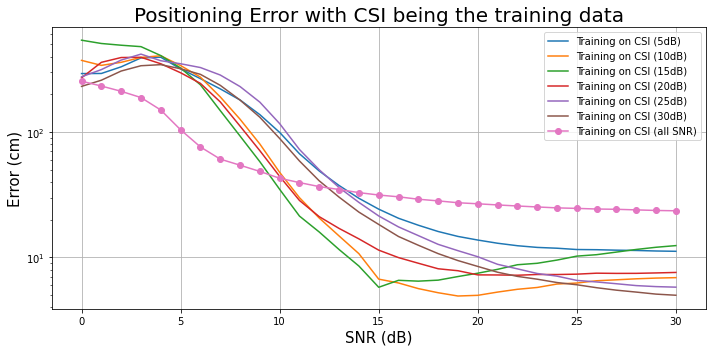

In [410]:
# def visualization(error_snr):
plt.figure(figsize=(10,5))
plt.plot(list(range(0,31)),model_5dBSNR_8antenna_train_on_CSI_only, label='Training on CSI (5dB)')
plt.plot(list(range(0,31)),model_10dBSNR_8antenna_train_on_CSI_only, label='Training on CSI (10dB)')
plt.plot(list(range(0,31)),model_15dBSNR_8antenna_train_on_CSI_only, label='Training on CSI (15dB)')
plt.plot(list(range(0,31)),model_20dBSNR_8antenna_train_on_CSI_only, label='Training on CSI (20dB)')
plt.plot(list(range(0,31)),model_25dBSNR_8antenna_train_on_CSI_only, label='Training on CSI (25dB)')
plt.plot(list(range(0,31)),model_30dBSNR_8antenna_train_on_CSI_only, label='Training on CSI (30dB)')
plt.plot(list(range(0,31)),model_train_on_0dB_to_30dB_SNR_8antenna_CSI, label='Training on CSI (all SNR)',linestyle='solid',marker='o')


plt.title(f'Positioning Error with CSI being the training data',size=20)
plt.xlabel('SNR (dB)',size=15)
plt.ylabel('Error (cm)',size=15)
plt.yscale("log")
plt.grid()
plt.legend(title_fontsize=50)
plt.savefig(f'CSI Only Positioning Error.png')
plt.tight_layout()
plt.show()


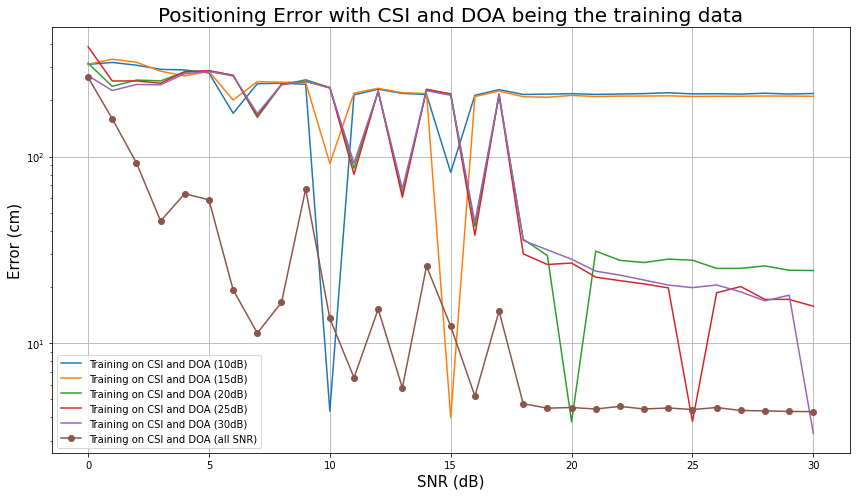

In [416]:
# def visualization(error_snr):
plt.figure(figsize=(12,7))
plt.plot(list(range(0,31)),model_10dBsNR_8antenna_train_on_both_doa_and_CSI, label='Training on CSI and DOA (10dB)')
plt.plot(list(range(0,31)),model_15dBsNR_8antenna_train_on_both_doa_and_CSI, label='Training on CSI and DOA (15dB)')
plt.plot(list(range(0,31)),model_20dBsNR_8antenna_train_on_both_doa_and_CSI, label='Training on CSI and DOA (20dB)')
plt.plot(list(range(0,31)),model_25dBsNR_8antenna_train_on_both_doa_and_CSI, label='Training on CSI and DOA (25dB)')
plt.plot(list(range(0,31)),model_30dBsNR_8antenna_train_on_both_doa_and_CSI, label='Training on CSI and DOA (30dB)')
plt.plot(list(range(0,31)),model_train_on_0dB_to_30dB_SNR_8antenna_CSI_and_DOA, label='Training on CSI and DOA (all SNR)',linestyle='solid',marker='o')

plt.title(f'Positioning Error with CSI and DOA being the training data',size=20)
plt.xlabel('SNR (dB)',size=15)
plt.ylabel('Error (cm)',size=15)
plt.yscale("log")
plt.grid()
plt.legend(title_fontsize=50, loc='lower left')
plt.savefig(f'CSI and DOA Positioning Error.png')
plt.tight_layout()
plt.show()


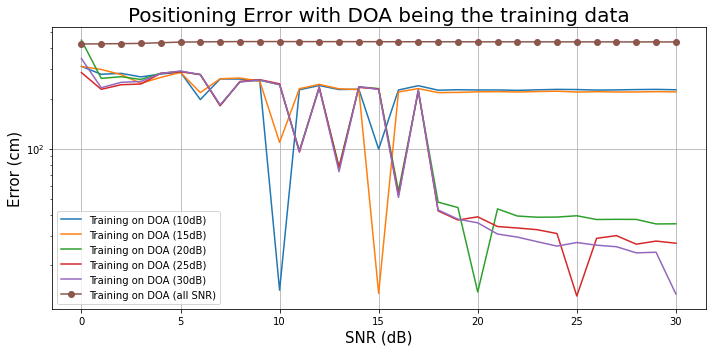

In [411]:
# def visualization(error_snr):
plt.figure(figsize=(10,5))
plt.plot(list(range(0,31)),model_10dBSNR_8antenna_train_on_DOA_only, label='Training on DOA (10dB)')
plt.plot(list(range(0,31)),model_15dBSNR_8antenna_train_on_DOA_only, label='Training on DOA (15dB)')
plt.plot(list(range(0,31)),model_20dBSNR_8antenna_train_on_DOA_only, label='Training on DOA (20dB)')
plt.plot(list(range(0,31)),model_25dBSNR_8antenna_train_on_DOA_only, label='Training on DOA (25dB)')
plt.plot(list(range(0,31)),model_30dBSNR_8antenna_train_on_DOA_only, label='Training on DOA (30dB)')
plt.plot(list(range(0,31)),model_train_on_0dB_to_30dB_SNR_8antenna_DOA, label='Training on DOA (all SNR)',linestyle='solid',marker='o')


plt.title(f'Positioning Error with DOA being the training data',size=20)
plt.xlabel('SNR (dB)',size=15)
plt.ylabel('Error (cm)',size=15)
plt.yscale("log")
plt.grid()
plt.legend(title_fontsize=50)
plt.savefig(f'Only DOA Positioning Error.png')
plt.tight_layout()
plt.show()


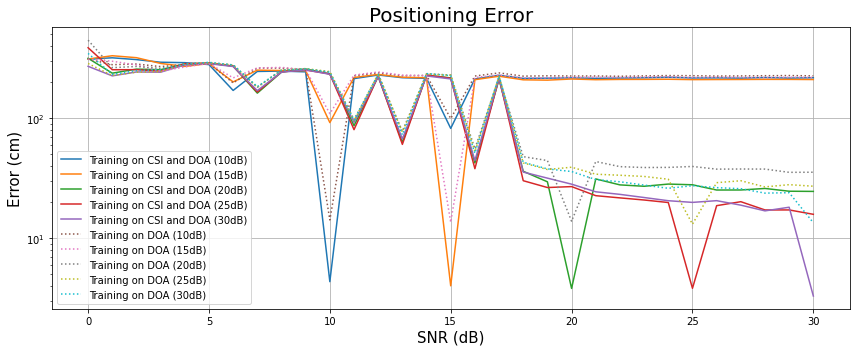

In [404]:
# def visualization(error_snr):
plt.figure(figsize=(12,5))
plt.plot(list(range(0,31)),model_10dBsNR_8antenna_train_on_both_doa_and_CSI, label='Training on CSI and DOA (10dB)')
plt.plot(list(range(0,31)),model_15dBsNR_8antenna_train_on_both_doa_and_CSI, label='Training on CSI and DOA (15dB)')
plt.plot(list(range(0,31)),model_20dBsNR_8antenna_train_on_both_doa_and_CSI, label='Training on CSI and DOA (20dB)')
plt.plot(list(range(0,31)),model_25dBsNR_8antenna_train_on_both_doa_and_CSI, label='Training on CSI and DOA (25dB)')
plt.plot(list(range(0,31)),model_30dBsNR_8antenna_train_on_both_doa_and_CSI, label='Training on CSI and DOA (30dB)')

plt.plot(list(range(0,31)),model_10dBSNR_8antenna_train_on_DOA_only, label='Training on DOA (10dB)',linestyle='dotted')
plt.plot(list(range(0,31)),model_15dBSNR_8antenna_train_on_DOA_only, label='Training on DOA (15dB)',linestyle='dotted')
plt.plot(list(range(0,31)),model_20dBSNR_8antenna_train_on_DOA_only, label='Training on DOA (20dB)',linestyle='dotted')
plt.plot(list(range(0,31)),model_25dBSNR_8antenna_train_on_DOA_only, label='Training on DOA (25dB)',linestyle='dotted')
plt.plot(list(range(0,31)),model_30dBSNR_8antenna_train_on_DOA_only, label='Training on DOA (30dB)',linestyle='dotted')

plt.title(f'Positioning Error',size=20)
plt.xlabel('SNR (dB)',size=15)
plt.ylabel('Error (cm)',size=15)
plt.yscale("log")
plt.grid()
plt.legend(title_fontsize=50)
plt.savefig(f'Only (DOA) and (CSI and DOA) Positioning Error Comparison.png')
plt.tight_layout()
plt.show()


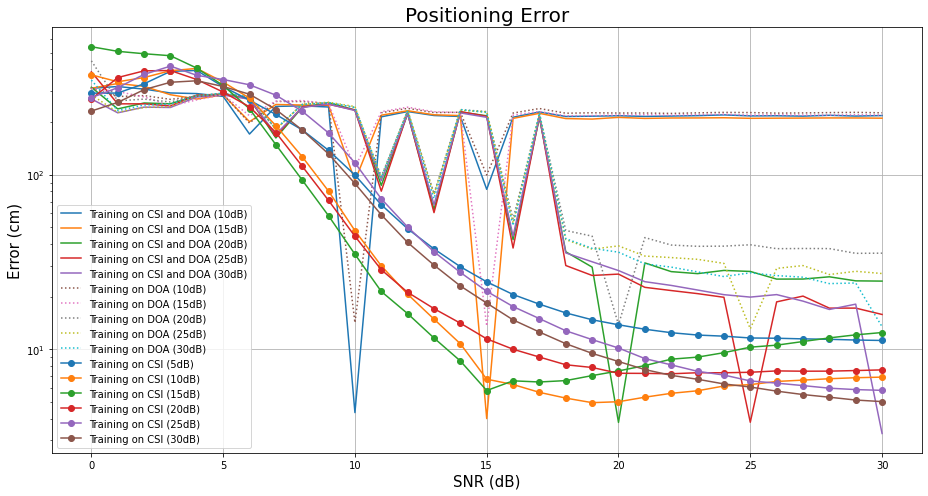

In [405]:
# def visualization(error_snr):
plt.figure(figsize=(13,7))
plt.plot(list(range(0,31)),model_10dBsNR_8antenna_train_on_both_doa_and_CSI, label='Training on CSI and DOA (10dB)')
plt.plot(list(range(0,31)),model_15dBsNR_8antenna_train_on_both_doa_and_CSI, label='Training on CSI and DOA (15dB)')
plt.plot(list(range(0,31)),model_20dBsNR_8antenna_train_on_both_doa_and_CSI, label='Training on CSI and DOA (20dB)')
plt.plot(list(range(0,31)),model_25dBsNR_8antenna_train_on_both_doa_and_CSI, label='Training on CSI and DOA (25dB)')
plt.plot(list(range(0,31)),model_30dBsNR_8antenna_train_on_both_doa_and_CSI, label='Training on CSI and DOA (30dB)')

plt.plot(list(range(0,31)),model_10dBSNR_8antenna_train_on_DOA_only, label='Training on DOA (10dB)',linestyle='dotted')
plt.plot(list(range(0,31)),model_15dBSNR_8antenna_train_on_DOA_only, label='Training on DOA (15dB)',linestyle='dotted')
plt.plot(list(range(0,31)),model_20dBSNR_8antenna_train_on_DOA_only, label='Training on DOA (20dB)',linestyle='dotted')
plt.plot(list(range(0,31)),model_25dBSNR_8antenna_train_on_DOA_only, label='Training on DOA (25dB)',linestyle='dotted')
plt.plot(list(range(0,31)),model_30dBSNR_8antenna_train_on_DOA_only, label='Training on DOA (30dB)',linestyle='dotted')

plt.plot(list(range(0,31)),model_5dBSNR_8antenna_train_on_CSI_only, label='Training on CSI (5dB)', marker='o')
plt.plot(list(range(0,31)),model_10dBSNR_8antenna_train_on_CSI_only, label='Training on CSI (10dB)', marker='o')
plt.plot(list(range(0,31)),model_15dBSNR_8antenna_train_on_CSI_only, label='Training on CSI (15dB)', marker='o')
plt.plot(list(range(0,31)),model_20dBSNR_8antenna_train_on_CSI_only, label='Training on CSI (20dB)', marker='o')
plt.plot(list(range(0,31)),model_25dBSNR_8antenna_train_on_CSI_only, label='Training on CSI (25dB)', marker='o')
plt.plot(list(range(0,31)),model_30dBSNR_8antenna_train_on_CSI_only, label='Training on CSI (30dB)', marker='o')

plt.title(f'Positioning Error',size=20)
plt.xlabel('SNR (dB)',size=15)
plt.ylabel('Error (cm)',size=15)
plt.yscale("log")
plt.grid()
plt.legend(title_fontsize=50)
plt.savefig(f'Positioning Error 3 comparison.png')
plt.tight_layout()
plt.show()


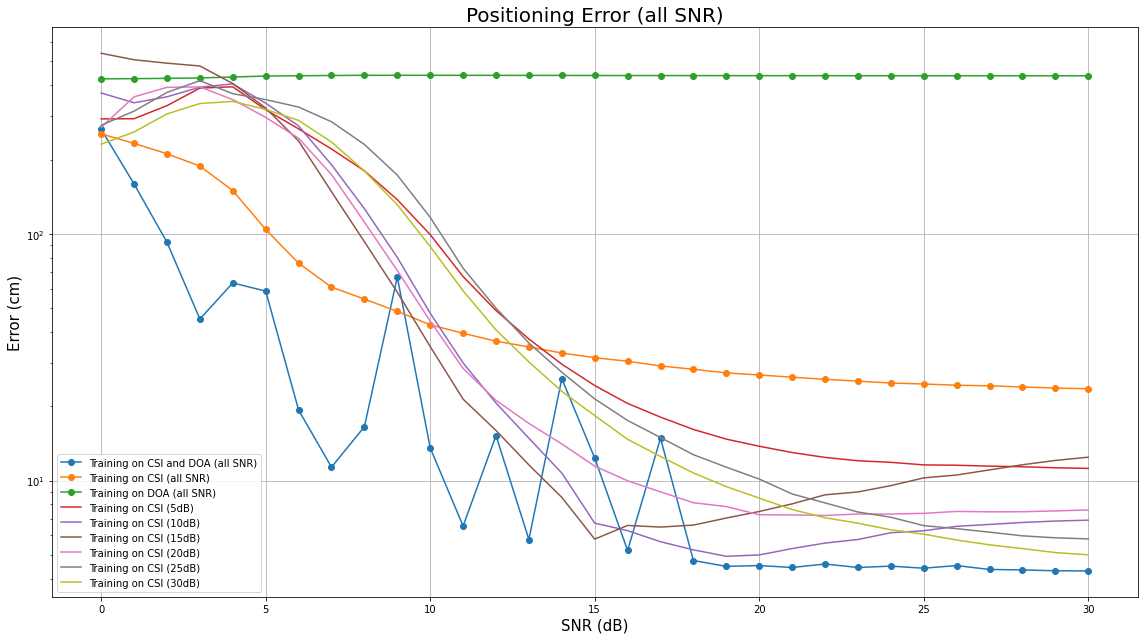

In [409]:
# def visualization(error_snr):
plt.figure(figsize=(16,9))
plt.plot(list(range(0,31)),model_train_on_0dB_to_30dB_SNR_8antenna_CSI_and_DOA, label='Training on CSI and DOA (all SNR)',linestyle='solid',marker='o')
plt.plot(list(range(0,31)),model_train_on_0dB_to_30dB_SNR_8antenna_CSI, label='Training on CSI (all SNR)',linestyle='solid',marker='o')
plt.plot(list(range(0,31)),model_train_on_0dB_to_30dB_SNR_8antenna_DOA, label='Training on DOA (all SNR)',linestyle='solid',marker='o')

plt.plot(list(range(0,31)),model_5dBSNR_8antenna_train_on_CSI_only, label='Training on CSI (5dB)')
plt.plot(list(range(0,31)),model_10dBSNR_8antenna_train_on_CSI_only, label='Training on CSI (10dB)')
plt.plot(list(range(0,31)),model_15dBSNR_8antenna_train_on_CSI_only, label='Training on CSI (15dB)')
plt.plot(list(range(0,31)),model_20dBSNR_8antenna_train_on_CSI_only, label='Training on CSI (20dB)')
plt.plot(list(range(0,31)),model_25dBSNR_8antenna_train_on_CSI_only, label='Training on CSI (25dB)')
plt.plot(list(range(0,31)),model_30dBSNR_8antenna_train_on_CSI_only, label='Training on CSI (30dB)')


plt.title(f'Positioning Error (all SNR)',size=20)
plt.xlabel('SNR (dB)',size=15)
plt.ylabel('Error (cm)',size=15)
plt.yscale("log")
plt.grid()
plt.legend(title_fontsize=50)
plt.savefig(f'Positioning Error for with all SNR.png')
plt.tight_layout()
plt.show()


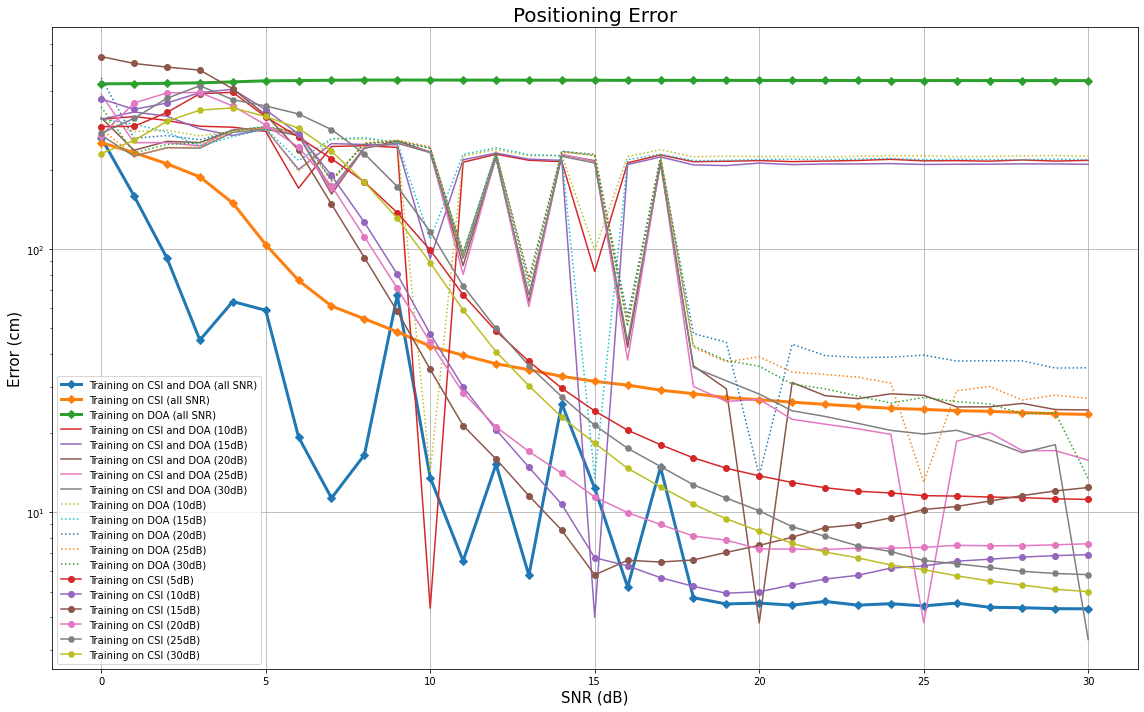

In [418]:
# def visualization(error_snr):
plt.figure(figsize=(16,10))
plt.plot(list(range(0,31)),model_train_on_0dB_to_30dB_SNR_8antenna_CSI_and_DOA, label='Training on CSI and DOA (all SNR)',linestyle='solid',marker='D',linewidth=3)
plt.plot(list(range(0,31)),model_train_on_0dB_to_30dB_SNR_8antenna_CSI, label='Training on CSI (all SNR)',linestyle='solid',marker='D',linewidth=3)
plt.plot(list(range(0,31)),model_train_on_0dB_to_30dB_SNR_8antenna_DOA, label='Training on DOA (all SNR)',linestyle='solid',marker='D',linewidth=3)

plt.plot(list(range(0,31)),model_10dBsNR_8antenna_train_on_both_doa_and_CSI, label='Training on CSI and DOA (10dB)')
plt.plot(list(range(0,31)),model_15dBsNR_8antenna_train_on_both_doa_and_CSI, label='Training on CSI and DOA (15dB)')
plt.plot(list(range(0,31)),model_20dBsNR_8antenna_train_on_both_doa_and_CSI, label='Training on CSI and DOA (20dB)')
plt.plot(list(range(0,31)),model_25dBsNR_8antenna_train_on_both_doa_and_CSI, label='Training on CSI and DOA (25dB)')
plt.plot(list(range(0,31)),model_30dBsNR_8antenna_train_on_both_doa_and_CSI, label='Training on CSI and DOA (30dB)')

plt.plot(list(range(0,31)),model_10dBSNR_8antenna_train_on_DOA_only, label='Training on DOA (10dB)',linestyle='dotted')
plt.plot(list(range(0,31)),model_15dBSNR_8antenna_train_on_DOA_only, label='Training on DOA (15dB)',linestyle='dotted')
plt.plot(list(range(0,31)),model_20dBSNR_8antenna_train_on_DOA_only, label='Training on DOA (20dB)',linestyle='dotted')
plt.plot(list(range(0,31)),model_25dBSNR_8antenna_train_on_DOA_only, label='Training on DOA (25dB)',linestyle='dotted')
plt.plot(list(range(0,31)),model_30dBSNR_8antenna_train_on_DOA_only, label='Training on DOA (30dB)',linestyle='dotted')

plt.plot(list(range(0,31)),model_5dBSNR_8antenna_train_on_CSI_only, label='Training on CSI (5dB)',marker='o')
plt.plot(list(range(0,31)),model_10dBSNR_8antenna_train_on_CSI_only, label='Training on CSI (10dB)',marker='o')
plt.plot(list(range(0,31)),model_15dBSNR_8antenna_train_on_CSI_only, label='Training on CSI (15dB)',marker='o')
plt.plot(list(range(0,31)),model_20dBSNR_8antenna_train_on_CSI_only, label='Training on CSI (20dB)',marker='o')
plt.plot(list(range(0,31)),model_25dBSNR_8antenna_train_on_CSI_only, label='Training on CSI (25dB)',marker='H')
plt.plot(list(range(0,31)),model_30dBSNR_8antenna_train_on_CSI_only, label='Training on CSI (30dB)',marker='H')

plt.title(f'Positioning Error',size=20)
plt.xlabel('SNR (dB)',size=15)
plt.ylabel('Error (cm)',size=15)
plt.yscale("log")
plt.grid()
plt.legend(title_fontsize=50)
plt.savefig(f'Positioning Error WITH EVERYTHING TOGETHER.png')
plt.tight_layout()
plt.show()
